<center>

<h1>Introduction to Machine Learning and Hybrid Intelligent Systems</h1>

<h2>Denis Torgunov</h2>

<h3>21st February 2018</h3>

</center>

<table align="left">
<tr>
<td><img src="img/github.png" alt="Github" width="50px"></td>
<td><pre>dtorgunov</pre></td>
</tr>
</table>

<div align="right">
<img src="img/qrcode.svg" alt="QR Code" width="150px">
</div>

The following includes the necessary input and initial setup for plotting and number manipulation, as well as machine learning.

In [1]:
from IPython.display import HTML # for producing html output in the notebook

import numpy as np # efficient number manipulation in Python

# Various libraries and settings necessary for plotting
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as path_effects

fig_size = [12, 9]
plt.rcParams["figure.figsize"] = fig_size
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# Machine learning and data set generation
import sklearn as sk
from sklearn import datasets # for the moons and circles data sets
from sklearn import svm # SVM training
from sklearn.neural_network import MLPClassifier # ANNs with back-propogation
from sklearn import tree # Decision trees
import graphviz # visualising decision trees

# Plotting helpers

The functions in this section abstract the common plotting logic. Axes on which to plot are given, along with training and testing data (each a tuple of points and labels), as well as an optional classifier (`clf`) with a type (only `'sklearn'` is used here).

If a classifier is not provided, only the points are plotted. Otherwise various classification regions and score on testing data are added to the plots.

In [2]:
def plot_data(ax, training, testing, clf = None, clf_type='sklearn'):
    (training_points, training_labels) = training
    (testing_points, testing_labels) = testing
    points = np.concatenate((training_points, testing_points))
    if clf is not None:
        min_x = np.min(np.transpose(points)[0]) - 0.5
        max_x = np.max(np.transpose(points)[0]) + 0.5
        min_y = np.min(np.transpose(points)[1]) - 0.5
        max_y = np.max(np.transpose(points)[1]) + 0.5
        xx, yy = np.meshgrid(np.arange(min_x, max_x, 0.02),
                         np.arange(min_y, max_y, 0.02))
        
        if clf_type == 'sklearn':
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        elif clf_type == 'ann':
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] 

        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
        
    ax.scatter(x = np.transpose(training_points)[0],
               y = np.transpose(training_points)[1],
               c=training_labels, cmap=cm_bright)
    ax.scatter(x = np.transpose(testing_points)[0],
               y = np.transpose(testing_points)[1],
               c=testing_labels, alpha=0.3, cmap=cm_bright)
    
    if clf is not None:
        score = 0
        
        if clf_type == 'sklearn' or clf_type == 'ann':
            score = clf.score(testing_points, testing_labels)
            
        ax.text(xx.max() - 0.2, yy.min() + 0.2, ('{0:.2f}'.format(score)),
           size=34, horizontalalignment='right', color='white', 
                path_effects=[path_effects.Stroke(linewidth=1, foreground='black')])

# What is Machine Learning?

+ Machine Learning (ML) is a multidisciplinary approach to pattern recognition, commonly used to "make sense" of large volumes of data by learning from the data themselves
+ It is impor that solutions generalise to new data
+ ML is one of the tools used with Big Data, both to learn about the data as well as to make decisions based on it

# Binary Classification & Regression

+ Binary Classification

  Find a model or function ("classifier") that will assign a class or label to any given input. The case where there are only two classes i known as "binary classification"
  
  $$y = f(\mathbf{x}) \quad \text{where} \quad y \in \{c_1, c_2\}$$
    
+ Regression

  Find a model or function that maps a given input to a continuous output
  
  $$y = f(\mathbf{x}) \quad \text{where} \quad y \in \mathbb{R}$$


# Example data sets

For the purposes of illustrating the algorithms discussed, we will consider a few artificially created data sets, split into training and testing data. The first two are generated using the `datasets` module from `sci-learn`.

The final data set is devised by [Lang and Witbrock (1988)](https://www.researchgate.net/publication/269337640_Learning_to_Tell_Two_Spirals_Apart), and generated using the C code provided by them.

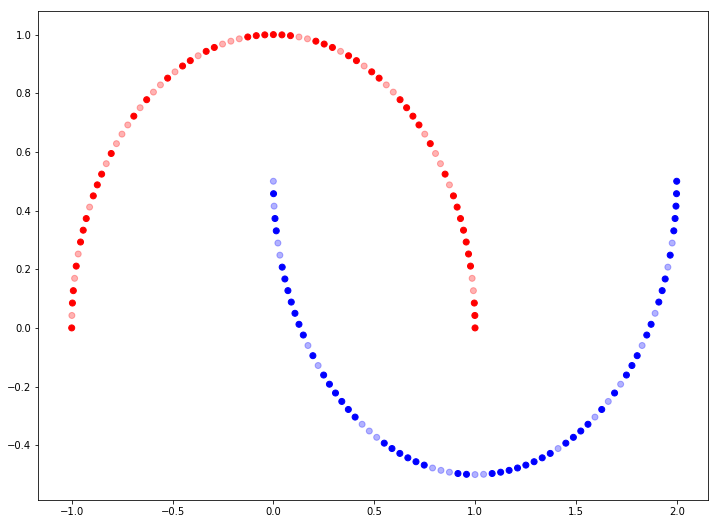

In [3]:
(points, labels) = datasets.make_moons(n_samples = 150)
training_moon_p = points[0:100:1]; training_moon_l = labels[0:100:1]
testing_moon_p = points[100:150:1]; testing_moon_l = labels[100:150:1]
fig, ax = plt.subplots(); plot_data(ax, (training_moon_p, training_moon_l),
                                  (testing_moon_p, testing_moon_l))

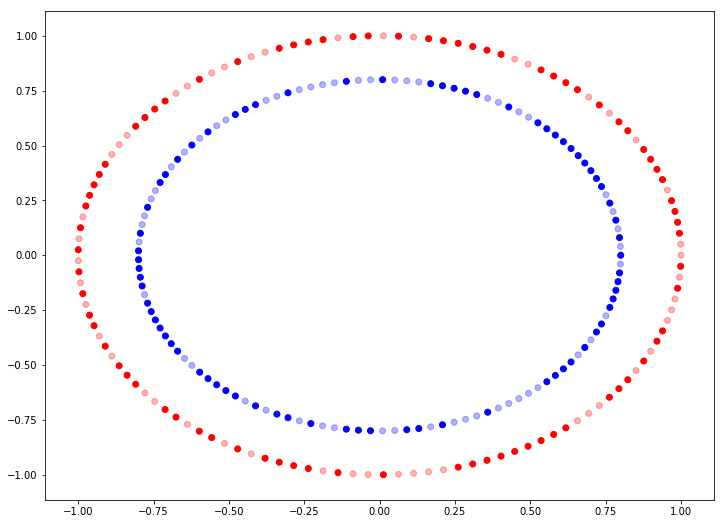

In [4]:
(points, labels) = datasets.make_circles(n_samples = 250, shuffle=True, noise=None)
training_circ_p = points[0:150:1]; training_circ_l = labels[0:150:1]
testing_circ_p = points[150:250:1]; testing_circ_l = labels[150:250:1]
fig, ax = plt.subplots(); plot_data(ax, (training_circ_p, training_circ_l),
                                  (testing_circ_p, testing_circ_l))

In [5]:
def load_spirals():
    data = np.loadtxt('data/two-spirals.csv', delimiter=',')
    
    # shuffle the data set (so that training and testing are not "in order")
    # with a reproducable random seed
    np.random.seed(12345) 
    np.random.shuffle(data)
    
    points = np.transpose(np.array((np.transpose(data)[0], np.transpose(data)[1])))
    labels = np.transpose(data)[2]
    return (points, labels)

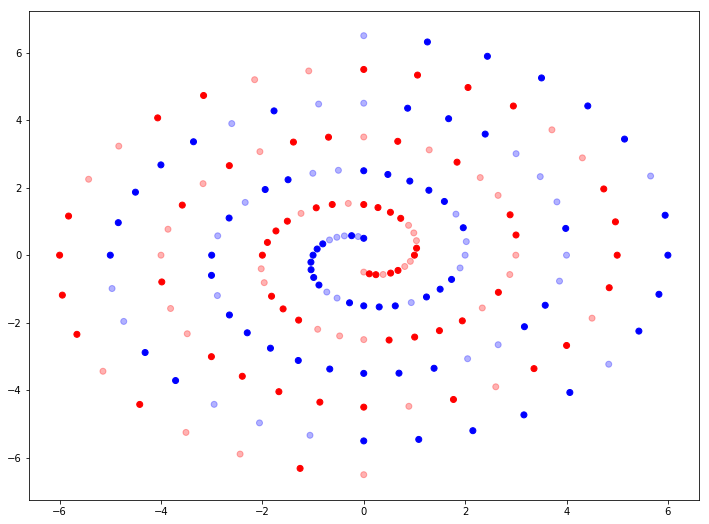

In [6]:
(points, labels) = load_spirals()
training_spir_p = points[0:120:1]; training_spir_l = labels[0:120:1]
testing_spir_p = points[120:194:1]; testing_spir_l = labels[120:194:1]
fig, ax = plt.subplots(); plot_data(ax, (training_spir_p, training_spir_l),
                                        (testing_spir_p, testing_spir_l))

# Support Vector Machines

Suppor Vector Machines (SVMs) construct separating hyperplanes between classes, aiming to maximise the margin of separation.

![An example of an SVM](img/svm.png "(Heart et al., 1998)")

# Linear SVM

The following is an example of using a linear SVM on each of the data sets. A consistent random seed is used in order to ensure the results are reproduciable exacly, here and in the functions below.

First, testing data accuracy is printed as a number, and then the real classification regions are plotted to show the "real picture".

In [7]:
clf = svm.LinearSVC(random_state=12345)
clf.fit(training_moon_p, training_moon_l)
HTML('<h3> Testing data accuracy: ' + str(clf.score(testing_moon_p, testing_moon_l)) + '</h3>')

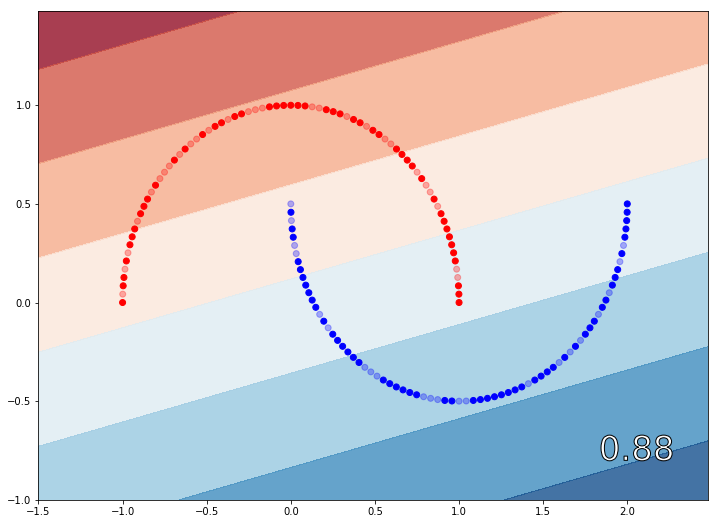

In [8]:
fig, ax = plt.subplots()
plot_data(ax, 
          (training_moon_p, training_moon_l), 
          (testing_moon_p, testing_moon_l), clf)

In [9]:
clf = svm.LinearSVC(random_state=12345)
clf.fit(training_circ_p, training_circ_l)
HTML('<h3> Testing data accuracy: ' + str(clf.score(testing_circ_p, testing_circ_l)) + '</h3>')

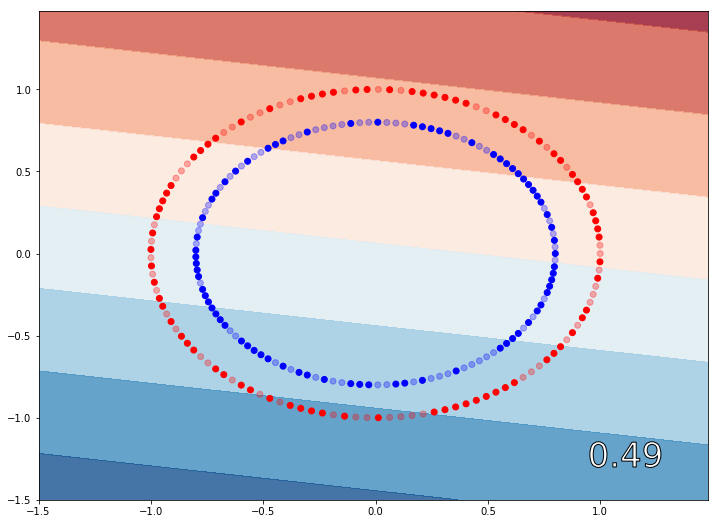

In [10]:
fig, ax = plt.subplots()
plot_data(ax, (training_circ_p, training_circ_l),
          (testing_circ_p, testing_circ_l), clf)

In [11]:
clf = svm.LinearSVC(random_state=12345)
clf.fit(training_spir_p, training_spir_l)
HTML('<h3> Testing data accuracy: ' + str(clf.score(testing_spir_p, testing_spir_l)) + '</h3>')

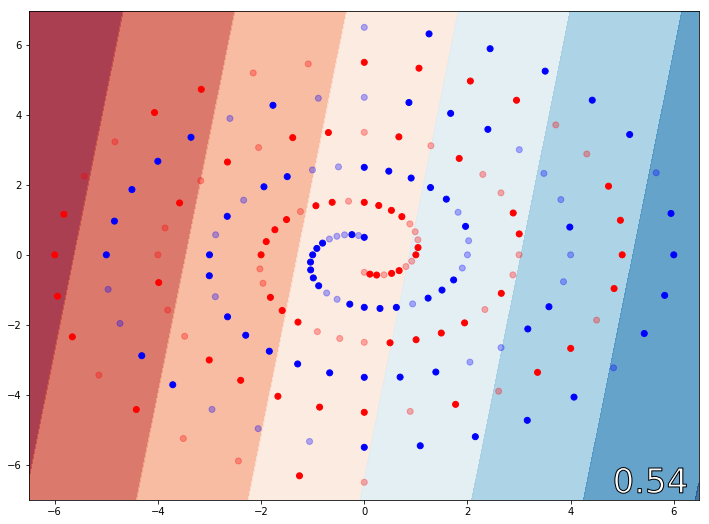

In [12]:
fig, ax = plt.subplots()
plot_data(ax, (training_spir_p, training_spir_l),
          (testing_spir_p, testing_spir_l), clf)

# The Kernel Trick

A techinque known as the *Kernel Trick* can be utilised to classify patterns which are not linearly separable by mapping them to a (often higher-dimensional) feature space in which they can be separated by a hyperplane

![Illustration of a kernel trick](img/kerneltrick.png "Image courtesy of Eric Kim")

# Using kernels

We now use the "kernel trick" to enhance the results from before. The default (radial basis) kernel is used, but it is interesting to see what results the use of different kernels produces.

In [13]:
clf = svm.SVC(gamma='auto', C=100.0, random_state=12345)
clf.fit(training_moon_p, training_moon_l)
HTML('<h3> Testing data accuracy: ' + str(clf.score(testing_moon_p, testing_moon_l)) + '</h3>')

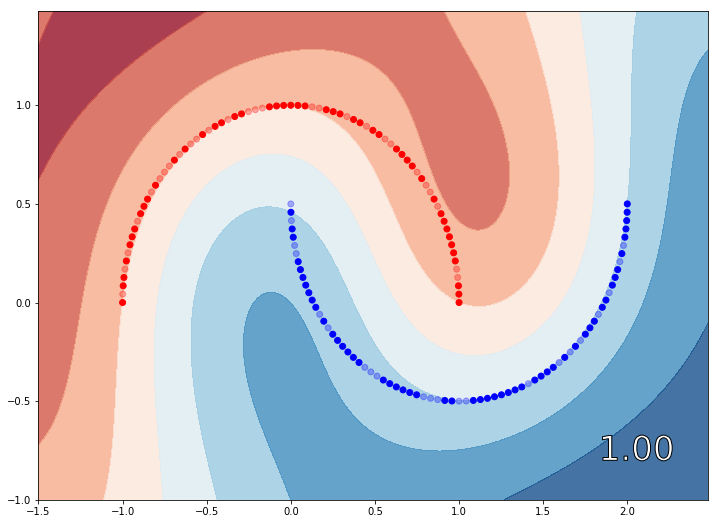

In [14]:
fig, ax = plt.subplots()
plot_data(ax, (training_moon_p, training_moon_l),
          (testing_moon_p, testing_moon_l), clf)

In [15]:
clf = svm.SVC(gamma='auto', C=100.0, random_state=12345)
clf.fit(training_circ_p, training_circ_l)
HTML('<h3> Testing data accuracy: ' + str(clf.score(testing_circ_p, testing_circ_l)) + '</h3>')

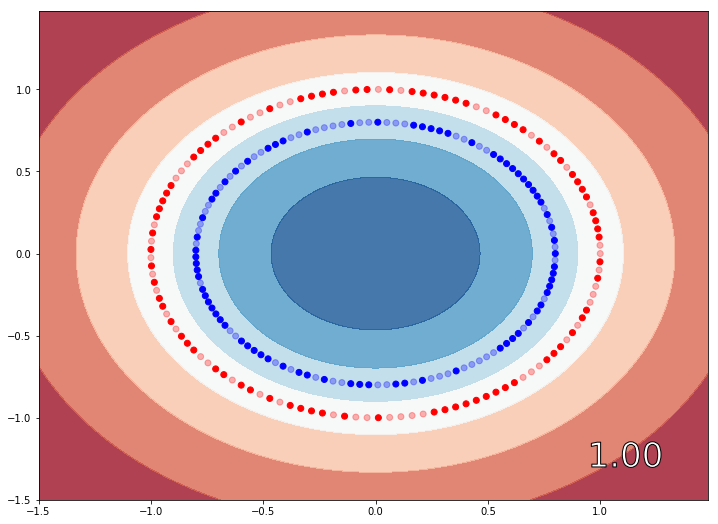

In [16]:
fig, ax = plt.subplots()
plot_data(ax, (training_circ_p, training_circ_l),
          (testing_circ_p, testing_circ_l), clf)

In [17]:
clf = svm.SVC(gamma='auto', C=100.0, random_state=12345)
clf.fit(training_spir_p, training_spir_l)
HTML('<h3> Testing data accuracy: ' + str(clf.score(testing_spir_p, testing_spir_l)) + '</h3>')

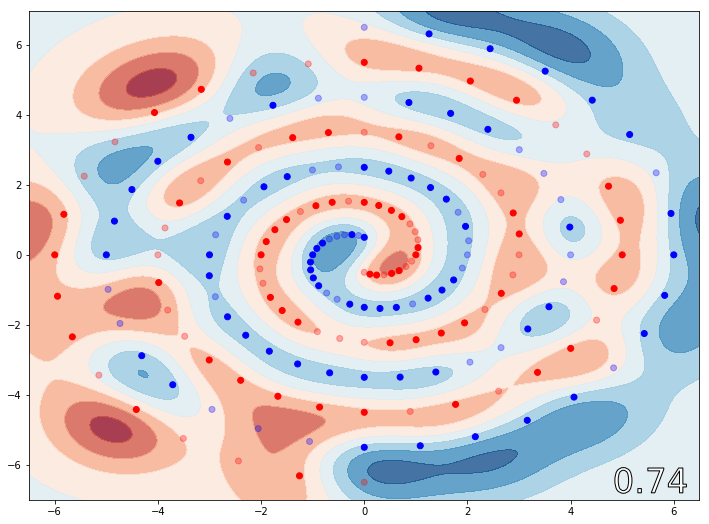

In [18]:
fig, ax = plt.subplots()
plot_data(ax, (training_spir_p, training_spir_l),
          (testing_spir_p, testing_spir_l), clf)

The results for spiral are particularly poor (due to a few places where the spirals are "broken" in the training set, leading to incorrect generalisation). When presented with the full data set, we can see that the spiral shape itself can be learned.

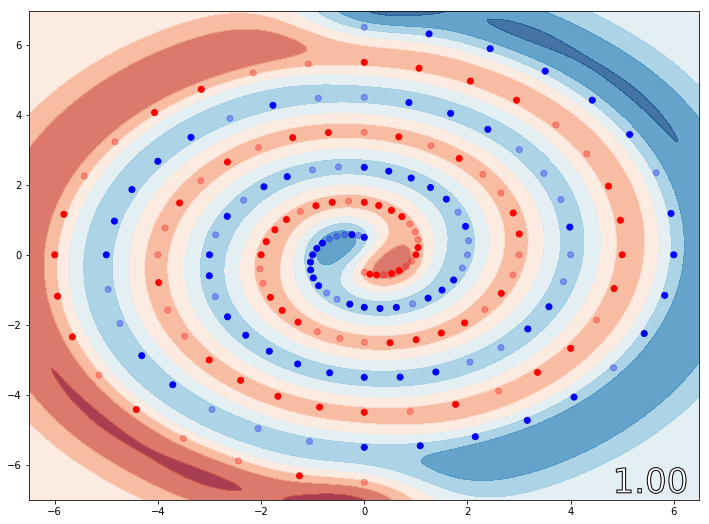

In [19]:
clf = svm.SVC(gamma='auto', C=100.0, random_state=12345)
clf.fit(points, labels); fig, ax = plt.subplots(); plot_data(ax, 
            (training_spir_p, training_spir_l), (testing_spir_p, testing_spir_l), clf)

# Result summary

In [20]:
def summary_svm():
    fig, axes = plt.subplots(2,3)

    fig.set_figwidth(14)

    clf = svm.LinearSVC(random_state=12345)
    clf.fit(training_circ_p, training_circ_l)
    plot_data(axes[0,1], (training_circ_p, training_circ_l), (testing_circ_p, testing_circ_l), clf)
    axes[0,1].set_title("Linear SVM, circles")

    clf = svm.LinearSVC(random_state=12345)
    clf.fit(training_moon_p, training_moon_l)
    plot_data(axes[0,0], (training_moon_p, training_moon_l), (testing_moon_p, testing_moon_l), clf)
    axes[0,0].set_title("Linear SVM, moons")

    clf = svm.SVC(gamma='auto', C=100.0, random_state=12345)
    clf.fit(training_circ_p, training_circ_l)
    plot_data(axes[1,1], (training_circ_p, training_circ_l), (testing_circ_p, testing_circ_l), clf)
    axes[1,1].set_title("Radial-basis SVM, circles")

    clf = svm.SVC(gamma='auto', C=100.0, random_state=12345)
    clf.fit(training_moon_p, training_moon_l)
    plot_data(axes[1,0], (training_moon_p, training_moon_l), (testing_moon_p, testing_moon_l), clf)
    axes[1,0].set_title("Radial-basis SVM, moons")

    clf = svm.LinearSVC(random_state=12345)
    clf.fit(training_spir_p, training_spir_l)
    plot_data(axes[0,2], (training_spir_p, training_spir_l), (testing_spir_p, testing_spir_l), clf)
    axes[0,2].set_title("Linear SVM, spirals")

    clf = svm.SVC(gamma='auto', C=100.0, random_state=12345)
    clf.fit(training_spir_p, training_spir_l)
    plot_data(axes[1,2], (training_spir_p, training_spir_l), (testing_spir_p, testing_spir_l), clf)
    axes[1,2].set_title("Radial-basis SVM, spirals")
    
    for ax1 in axes:
        for ax in ax1:
            ax.set_xticks(())
            ax.set_yticks(())

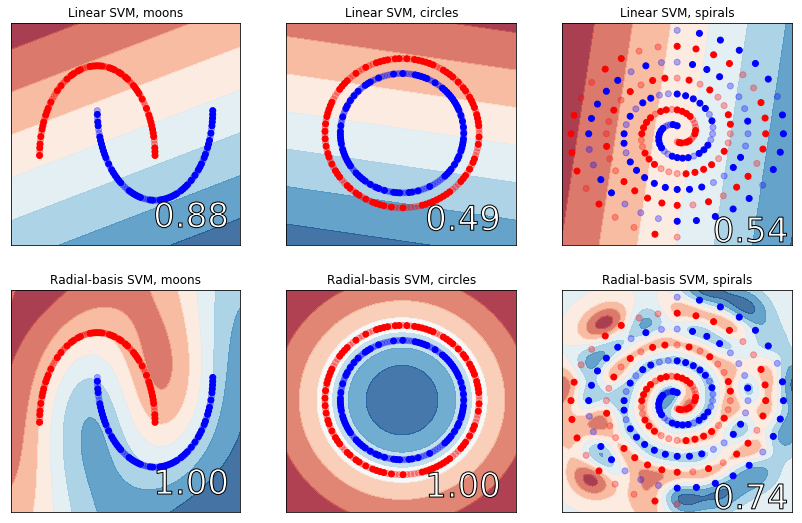

In [21]:
summary_svm()